In [29]:
import numpy as np

## Represents a collection Molecule objects that can be evaluated and counted
class ConformerCounter:
    
    ## EFFECTS: Constructs a ConformerCounter with list of Molecule objects from given gro coordinates, itp bond topologies,
    ## and sets the appropriate bonds, carbon rings, and substitutions
    ## REQUIRES: itp bond topologies must correspond to molecule type in gro coordinate file
    def __init__(self, gro, itp):
        self.molecules = []
        
        bonds, atomCount = self.itpReader(itp)

        self.atomCount = atomCount

        self.groReader(gro, atomCount) 
        self.atomBonder(bonds)
        self.ringConnector()
        self.substitutionFinder()
    
    ## EFFECTS: extracts atom name and coordinate data from gro file, and creates Atom objects and adds them Molecule objects
    ## MODIFIES: self
    def groReader(self, filename, atomCount):    

        residueNumber = []
        atomName = []
        x = []
        y = []
        z = []

        groFile = open(filename) 
        lines = groFile.readlines()[2:-1]

        notAtEnd = True

        dataIndex = 0
        
        while notAtEnd:
            molecule = self.Molecule()
            atomNumber = 1
            for i in range(dataIndex, dataIndex + atomCount):

                data = lines[i]

                atomName = data[12:15].strip()
                x = float(data[20:28])
                y = float(data[28:36])
                z = float(data[36:44])

                atom = self.Atom(atomNumber, atomName, x, y, z)
                molecule.addAtom(atom)

                atomNumber +=1
            dataIndex += atomCount

            if dataIndex + atomCount > len(lines):
                notAtEnd = False

            self.molecules.append(molecule)

        groFile.close()

    ## EFFECTS: Searches for atoms that are supposed to be connected and sets them to be bonded to each other
    ## MODIFIES: self
    def atomBonder(self, bonds):

        for molecule in self.molecules:
            for atom1 in molecule.getAtoms():
                for atom2 in molecule.getAtoms():
                    for bond in bonds:
                        if bond[0] == atom1.getNumber() and bond[1] == atom2.getNumber():
                            atom1.addBonded(atom2)
                            atom2.addBonded(atom1)

    ## EFFECTS: Extracts bond connectivity data and atom count from itp file
    def itpReader(self, filename):

        itpFile = open(filename)
        lines = itpFile.readlines()

        titleIndex = 0
        for line in lines:
            if "[ atoms ]" in line:
                break
            titleIndex +=1 

        atomIndex = titleIndex + 2

        atomCount = 0
        for i in range(atomIndex, len(lines)):
            if lines[i] != "\n":
                atomCount += 1
            else:
                break

        titleIndex = 0
        for line in lines:
            if "[ bonds ]" in line:
                break
            titleIndex +=1 

        bondIndex = titleIndex + 2

        bonds = []

        for i in range(bondIndex, len(lines)):
            if lines[i] != "\n":
                row = lines[i].strip().split()
                bond = [int(row[0]), int(row [1])]
                bonds.append(bond)
            else:
                break

        return bonds, atomCount

    ## EFFECTS: Recursively searches for 6 carbons that connected to one another in a loop and returns them
    ## in an ordered list
    def ringSearch(self, atom, ringList):
        if atom.getName() == "C" and not atom in ringList:
            ringList.append(atom)
            if len(ringList) == 6:
                loops = False
                for connectedAtom in ringList[5].getBonded():
                    if connectedAtom == ringList[0]:
                        loops = True
                if loops:
                    return ringList
                else:
                    return False
            else:
                for connectedAtom in atom.getBonded():
                    result = self.ringSearch(connectedAtom,ringList)
                    if result != False:
                        return result
        else:
            return False

    ## EFFECTs: Adds carbon in a ring to ring carbons list in each molecule
    ## MODIFIES: self
    def ringConnector(self):

        for molecule in self.molecules:
            carbonsToAdd = []
            for atom in molecule.getAtoms():
                ringCarbons = self.ringSearch(atom, [])
                if ringCarbons != False:
                    carbonsToAdd = ringCarbons
                    break

            for carbon in carbonsToAdd:
                molecule.getAtoms().remove(carbon)
                molecule.getCarbons().append(carbon)

            for i in range(6):
                if i+1 != 6:
                    molecule.getCarbons()[i].setNext(molecule.getCarbons()[i+1])
                else:
                    molecule.getCarbons()[i].setNext(molecule.getCarbons()[0]) 

    ## EFFECTS: finds non hydrogen substitutions on carbon ring and assigns it to the molecule 
    ## MODIFIES: self
    def substitutionFinder(self):

        for molecule in self.molecules:
            for carbon in molecule.getCarbons():
                for connectedAtom in carbon.getBonded():
                    if connectedAtom not in molecule.getCarbons() and connectedAtom.getName() != "H":
                        molecule.assignSubstitution(carbon, connectedAtom)
    
    ## Represents a molecule with list of Atom objects, ring carbons, a substitution, and conformation assignments
    class Molecule:
        
        ## Constructs an empty molecule with no assignments
        def __init__(self): 
            self.ringCarbons = []
            self.otherAtoms = []

            self.subCarbon = None
            self.subAtom = None

            self.chair = False
            self.twistBoat = False      

            self.equatorial = False
            self.axial = False

        def isChair(self):
            return self.chair

        def isTwistBoat(self):
            return self.twistBoat

        def isEquatorial(self):
            return self.equatorial

        def isAxial(self):
            return self.axial

        def resetChair(self):
            self.chair = False
            self.twistBoat = False
        
        def resetEquatorial(self):
            self.equatorial = False
            self.axial = False

        def isSubstituted(self):
            return self.subCarbon and self.subAtom

        def addCarbon(self, atom):
            self.ringCarbons.append(atom)    

        def getCarbons(self):
            return self.ringCarbons

        def addAtom(self, atom):
            self.otherAtoms.append(atom)

        def getAtoms(self):
            return self.otherAtoms

        def assignSubstitution(self, carbon, subAtom):
            self.subCarbon = carbon
            self.subAtom = subAtom  
        
        ## EFFECTS: Determines if two vectors point in the same direction
        def sameDirection(self,v1,v2):
            sameDirection = False
            if v1 != None and v2 != None:
                dotProduct = np.dot(v1,v2) / self.magnitude(v1) / self.magnitude(v2)
                sameDirection = dotProduct > 0
            return sameDirection

        ## EFFECTS: Determines if two vectors are within given angle of each other
        def isParallel(self,v1,v2,toleranceAngle):
            dotProduct = np.dot(v1,v2) / self.magnitude(v1) / self.magnitude(v2)
            parallel = abs(dotProduct) >= np.cos(toleranceAngle/360 * 2*np.pi)
            return parallel              

        ## EFFECTS: Returns a vector from atom1 to atom2
        def vector(self, atom1, atom2):
            xLength = atom2.getX() - atom1.getX()
            yLength = atom2.getY() - atom1.getY()
            zLength = atom2.getZ() - atom1.getZ()
            return [xLength, yLength, zLength]

        ## EFFECTS: Returns the magnitude of a given vector
        def magnitude(self,vector):
            magnitude = (vector[0]**2 + vector[1]**2 + vector[2]**2)**(1 / 2)
            return magnitude        
        
        ## EFFECTS: If substituted, recursively searches for axial vectors and determines if the vectors follow
        ## the direction pattern expected for an axial substitued bond and makes appropriate assignments
        ## MODIFIES: self
        def assignEquatorial(self, axialTolAngle):

            if self.isSubstituted() and self.isChair():
                axialVectorsList = self.axialHSearch(5, self.subCarbon.getNextX(1), [], axialTolAngle)            
                if axialVectorsList:
                    subVector = self.vector(self.subCarbon, self.subAtom)
                    isAxial = False                
                    for axialVectors in axialVectorsList:
                        desiredDirection = False                    
                        patternCorrect = True
                        for axialVector in axialVectors:
                            direction = self.sameDirection(axialVector,subVector)
                            if desiredDirection != direction:
                                patternCorrect = False
                                break
                            desiredDirection = not desiredDirection
                        if patternCorrect:
                            isAxial = True
                            break
                    if isAxial:
                        self.axial = True
                        self.equatorial = False
                    else:
                        self.axial = False
                        self.equatorial = True
                        
        ## EFFECTS: Returns list of list of bond vectors around the carbon ring that are all parallel within a range
        def axialHSearch(self, total, carbon, vectorList, axialTolAngle):

            if len(vectorList) == total:
                allParallel = True
                for i in range(5):
                    for j in range(i+1,5):
                        if not self.isParallel(vectorList[i], vectorList[j], axialTolAngle):
                            allParallel = False
                            break
                    if allParallel == False:
                        break
                if allParallel:
                    return [vectorList]
            else:
                totalResult = []
                for connectedAtom in carbon.getBonded():
                    if not connectedAtom in self.ringCarbons:
                        branchVectorList = vectorList.copy()
                        branchVectorList.append(self.vector(carbon, connectedAtom))
                        branch = self.axialHSearch(5, carbon.getNextX(1), branchVectorList, axialTolAngle)
                        if branch:
                            totalResult += branch
                if totalResult:
                    return totalResult
        
        ## EFFECTS: Searches for axial vectors and determines if the vectors follow the direction pattern for a chair
        ## cyclohexane with reference to one axial bond, and makes appropriate assignments to molecule
        ## MODIFIES: self
        def assignChair(self, chairTolAngle):

            axialVectorsList = self.axialHSearch(6, self.ringCarbons[0], [], chairTolAngle)
            if axialVectorsList:
                isChair = False
                for axialVectors in axialVectorsList:                
                    refVector = axialVectors[0]
                    desiredDirection = False
                    patternCorrect = True
                    for axialVector in axialVectors[1:]:
                        direction = self.sameDirection(axialVector, refVector)
                        if desiredDirection != direction:
                            patternCorrect = False
                            break
                        desiredDirection = not desiredDirection
                    if patternCorrect:
                        isChair = True
                        break
                if isChair:
                    self.chair = True
                    self.twistBoat = False                
                else: 
                    self.chair = False
                    self.twistBoat = True

            
    ## Represents an Atom with a number, number (within molecule), coordinates, atoms it is bonded to, 
    ## and the next atom in the carbon ring (if it is a ring carbon)
    class Atom:
        
        ## EFFECTS: Constructs an atom with a number, name, coordinates, without bonds or a next ring atom
        def __init__(self,number, name, x, y, z):
            self.number = number
            self.name = name

            self.x = x
            self.y = y 
            self.z = z

            self.bonded = []
            self.next = None

        def getNumber(self):
            return self.number

        def getName(self):
            return self.name

        def getX(self):
            return self.x

        def getY(self):
            return self.y

        def getZ(self):
            return self.z  

        def addBonded(self, atom):
            self.bonded.append(atom)

        def getBonded(self):
            return self.bonded

        def setNext(self, atom):
            self.next = atom
        
        ## EFFECTS: returns the next atom in the ring carbon, with steps of n size
        def getNextX(self, n):
            nextAtom = self
            for i in range(n):
                nextAtom = nextAtom.next
            return nextAtom    

    ## EFFECTS: Counts and graphs the equatorial / axial count of molecule at every angle of tolerance 0-90
    ## MODIFIES: self
    def equatorialCounter(self, chairTolAngle):
        
        angle = []
        eq = []
        axial = []
        print("Angle | Equatorial | Axial") 
        
        for molecule in self.molecules:
            molecule.resetEquatorial()
            molecule.resetChair()
            molecule.assignChair(chairTolAngle)
        for i in range(0,91):
            axialCount = 0
            eqCount = 0
            for molecule in self.molecules:
                molecule.resetEquatorial()
                molecule.assignEquatorial(i)
                if molecule.isAxial():
                    axialCount += 1
                if molecule.isEquatorial():
                    eqCount += 1
            print(str(i) + " " + str(eqCount) + " " + str(axialCount))
            angle.append(i)
            eq.append(eqCount)
            axial.append(axialCount)
            
        import matplotlib.pyplot as pp
        pp.plot(angle, eq, label = "Equatorial")
        pp.plot(angle, axial, label = "Axial")
        pp.xlabel("Angle Tolerance (deg)")
        pp.ylabel("Molecule Count")
        pp.title('Equatorial / Axial to Tolerance Relationship')
        pp.legend()
        pp.show()
     
    ## EFFECTS: Counts and graphs the chair / twist boat count of molecule at every angle of tolerance 0-90
    ## MODIFIES: self
    def chairCounter(self):

        angle = []
        chair = []
        twistBoat = []
        print("Angle | Chairs | Twist Boats")     
        
        for molecule in self.molecules:
            molecule.resetEquatorial()
            molecule.resetChair()
        
        for i in range(0,91):
            chairCount = 0
            tBoatCount = 0
            for molecule in self.molecules:
                molecule.resetChair()
                molecule.assignChair(i)
                if molecule.isChair():
                    chairCount += 1
                if molecule.isTwistBoat():
                    tBoatCount += 1
            print(str(i) + " " + str(chairCount) + " " + str(tBoatCount))
            angle.append(i)
            chair.append(chairCount)
            twistBoat.append(tBoatCount)
            
        import matplotlib.pyplot as pp
        pp.plot(angle, chair, label = "Chair")
        pp.plot(angle, twistBoat, label = "Not Chair")
        pp.xlabel("Angle Tolerance (deg)")
        pp.ylabel("Molecule Count")
        pp.title('Chair Count to Tolerance Relationship')
        pp.legend()
        pp.show()

    ## EFFECTS: Counts given angle of tolerance 0-90 and writes a new gro file with molecules given the desired assignment
    ## for diagnostics purposes
    ## MODIFIES: self
    def groFilterer(self, chairTolAngle, axialTolAngle, option):

        for molecule in self.molecules:
            molecule.resetChair()
            molecule.resetEquatorial()
            molecule.assignChair(chairTolAngle)
            molecule.assignEquatorial(axialTolAngle)

        chairCount = 0
        tBoatCount = 0
        axialCount = 0
        eqCount = 0

        moleculesToPrint = []

        for molecule in self.molecules:
            if molecule.isChair():
                chairCount += 1
                if option == "chair":
                    moleculesToPrint.append(molecule)  
            if molecule.isTwistBoat():
                tBoatCount += 1
                if option == "twistBoat":
                    moleculesToPrint.append(molecule)  
            if molecule.isAxial():
                axialCount += 1
                if option == "axial":
                    moleculesToPrint.append(molecule)  
            if molecule.isEquatorial():
                eqCount += 1
                if option == "equatorial":
                    moleculesToPrint.append(molecule)                  
            if not molecule.isTwistBoat() and not molecule.isChair():
                if option == "unresolved":
                    moleculesToPrint.append(molecule)            

        print("Chair: " + str(chairCount))
        print("Twist Boat: " + str(tBoatCount))
        print("Axial: " + str(axialCount))
        print("Equatorial: " + str(eqCount))


        if moleculesToPrint:
            moleculeNumber = len(moleculesToPrint)

            file = open("printout.gro","w")

            file.write("Sample Molecule\n{:5d}".format(self.atomCount*moleculeNumber))
            file.write("\n")
        
            moleculeIndex = 1
            for molecule in moleculesToPrint:
                atomIndex = 1

                for atom in molecule.getCarbons():
                    file.write("{:5d}{:>10}{:5d}{:8.3f}{:8.3f}{:8.3f}".format(moleculeIndex, atom.getName(), atomIndex, atom.getX(),  atom.getY(), atom.getZ()))
                    file.write("\n")
                    atomIndex += 1

                for atom in molecule.getAtoms():
                    file.write("{:5d}{:>10}{:5d}{:8.3f}{:8.3f}{:8.3f}".format(moleculeIndex, atom.getName(), atomIndex, atom.getX(),  atom.getY(), atom.getZ()))
                    file.write("\n")
                    atomIndex += 1

                moleculeIndex += 1
                
            file.write("  50.00000  50.00000  50.00000\n")

            print("\n" + option + " molecules written to printout.gro")
        else:
            print("\ninvalid selection: " + option)


In [11]:
methyl1830 = ConformerCounter("methyl_1000_opls_1830.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 1 0
16 1 0
17 1 0
18 2 0
19 3 0
20 4 0
21 6 1
22 7 1
23 10 1
24 12 1
25 14 1
26 22 1
27 26 2
28 30 6
29 32 9
30 38 10
31 43 14
32 50 19
33 59 24
34 64 35
35 72 45
36 79 50
37 85 62
38 91 71
39 96 81
40 106 102
41 116 129
42 128 147
43 141 177
44 149 197
45 158 226
46 170 265
47 182 297
48 190 329
49 197 359
50 207 389
51 212 429
52 219 460
53 229 483
54 234 513
55 242 539
56 246 564
57 251 591
58 264 605
59 274 617
60 282 627
61 289 648
62 291 657
63 298 662
64 304 669
65 313 668
66 324 659
67 337 651
68 347 644
69 357 636
70 362 633
71 371 625
72 376 622
73 388 612
74 398 602
75 408 592
76 415 585
77 422 578
78 430 570
79 444 556
80 457 543
81 469 531
82 489 511
83 505 495
84 530 470
85 557 443
86 593 407
87 626 374
88 676 324
89 718 282
90 778 222


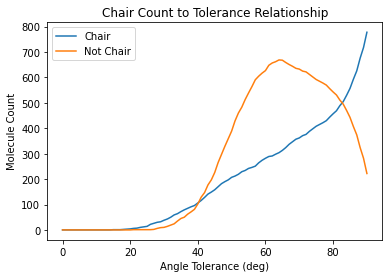

In [64]:
methyl1830.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 1 0
19 1 1
20 2 1
21 3 1
22 4 1
23 7 2
24 8 2
25 8 4
26 10 7
27 12 9
28 12 12
29 14 14
30 18 18
31 21 21
32 24 25
33 30 28
34 34 33
35 34 35
36 40 39
37 45 40
38 53 41
39 57 45
40 62 49
41 69 51
42 75 55
43 89 58
44 93 61
45 98 63
46 108 68
47 120 73
48 126 77
49 132 80
50 141 82
51 145 84
52 153 85
53 158 88
54 165 88
55 170 89
56 172 92
57 175 94
58 175 97
59 176 99
60 178 102
61 179 102
62 179 103
63 178 104
64 177 105
65 177 105
66 177 105
67 177 105
68 177 105
69 177 105
70 177 105
71 177 105
72 177 105
73 177 105
74 177 105
75 177 105
76 176 106
77 176 106
78 175 107
79 175 107
80 175 107
81 175 107
82 175 107
83 175 107
84 175 107
85 175 107
86 175 107
87 175 107
88 175 107
89 175 107
90 174 108


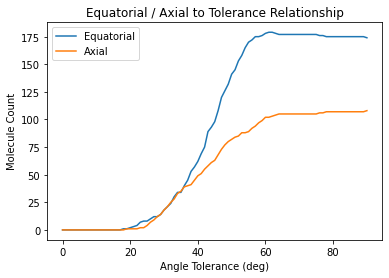

In [28]:
methyl1830.equatorialCounter(60)

In [28]:
methyl298 = ConformerCounter("methyl_1000_opls_298.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 1 0
6 1 0
7 1 0
8 5 0
9 7 0
10 18 0
11 29 0
12 47 0
13 71 0
14 102 0
15 136 0
16 179 0
17 225 0
18 276 0
19 341 0
20 400 0
21 467 0
22 509 0
23 563 0
24 614 0
25 658 0
26 695 0
27 726 0
28 769 0
29 812 1
30 841 1
31 866 1
32 887 1
33 903 2
34 919 2
35 929 3
36 933 4
37 941 6
38 944 6
39 946 7
40 949 7
41 951 7
42 954 8
43 961 10
44 964 10
45 965 12
46 967 13
47 968 16
48 970 16
49 971 15
50 971 18
51 973 19
52 973 20
53 973 23
54 973 26
55 973 26
56 973 26
57 973 27
58 973 27
59 974 26
60 974 26
61 974 26
62 974 26
63 974 26
64 974 26
65 974 26
66 974 26
67 974 26
68 974 26
69 974 26
70 974 26
71 974 26
72 974 26
73 974 26
74 974 26
75 974 26
76 974 26
77 974 26
78 974 26
79 974 26
80 974 26
81 975 25
82 975 25
83 976 24
84 976 24
85 978 22
86 980 20
87 983 17
88 984 16
89 989 11
90 991 9


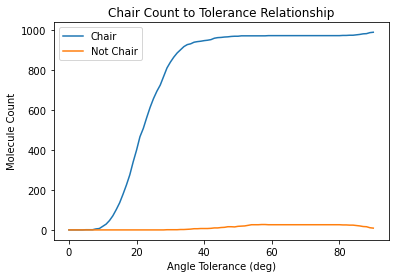

In [29]:
methyl298.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 3 0
9 4 0
10 7 0
11 13 0
12 22 0
13 43 0
14 64 0
15 85 0
16 117 0
17 160 0
18 219 0
19 283 1
20 328 1
21 383 2
22 436 2
23 504 2
24 548 4
25 595 5
26 634 5
27 670 5
28 718 6
29 764 7
30 796 8
31 831 9
32 857 9
33 869 10
34 887 11
35 901 13
36 909 13
37 919 13
38 924 13
39 928 13
40 932 13
41 936 13
42 940 13
43 946 13
44 950 13
45 951 13
46 954 13
47 955 13
48 958 13
49 959 13
50 959 13
51 961 13
52 961 13
53 961 13
54 961 13
55 961 13
56 961 13
57 961 13
58 961 13
59 961 13
60 961 13
61 961 13
62 961 13
63 961 13
64 961 13
65 961 13
66 961 13
67 961 13
68 961 13
69 961 13
70 961 13
71 961 13
72 961 13
73 961 13
74 961 13
75 961 13
76 961 13
77 961 13
78 961 13
79 961 13
80 961 13
81 961 13
82 961 13
83 961 13
84 961 13
85 961 13
86 961 13
87 961 13
88 961 13
89 961 13
90 961 13


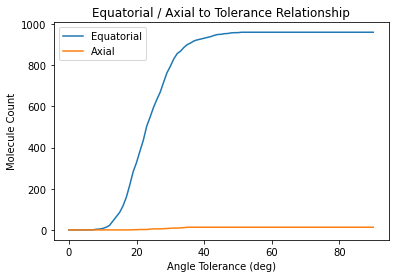

In [30]:
methyl298.equatorialCounter(60)

In [33]:
cyclohexane1830 = ConformerCounter("cyclohexane_1000_opls_1830.gro", "cyclohexane_1_opls.itp")

In [34]:
cyclohexane1830.groFilterer(60, 60, "twistBoat")

Chair: 242
Twist Boat: 643
Axial: 0
Equatorial: 0

twistBoat molecules written to printout.gro


Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 1 0
18 2 0
19 2 1
20 5 1
21 5 1
22 6 1
23 8 1
24 9 1
25 13 2
26 14 4
27 16 7
28 19 10
29 23 13
30 28 14
31 35 17
32 42 22
33 48 27
34 53 34
35 58 41
36 64 52
37 67 67
38 78 90
39 81 103
40 85 117
41 93 136
42 96 152
43 103 185
44 110 207
45 122 227
46 126 256
47 133 289
48 143 319
49 154 353
50 159 385
51 169 413
52 175 446
53 182 479
54 193 513
55 200 547
56 211 573
57 217 592
58 227 617
59 233 633
60 242 643
61 251 660
62 262 668
63 266 676
64 271 686
65 276 694
66 283 695
67 297 690
68 306 686
69 320 676
70 326 671
71 338 660
72 347 651
73 363 636
74 369 631
75 375 625
76 383 617
77 392 608
78 409 591
79 423 577
80 432 568
81 445 555
82 461 539
83 484 516
84 501 499
85 536 464
86 570 430
87 609 391
88 659 341
89 713 287
90 766 234


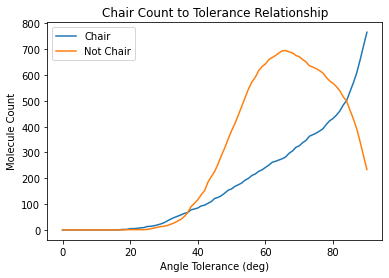

In [32]:
cyclohexane1830.chairCounter()

In [35]:
cyclohexanel298 = ConformerCounter("cyclohexane_1000_opls_298.gro", "cyclohexane_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 1 0
10 2 0
11 8 0
12 16 0
13 24 0
14 35 0
15 57 0
16 78 0
17 101 0
18 138 0
19 166 0
20 213 0
21 265 0
22 323 0
23 371 0
24 420 0
25 473 0
26 528 0
27 568 0
28 603 0
29 633 1
30 667 1
31 701 2
32 725 3
33 748 5
34 768 5
35 790 6
36 809 9
37 820 12
38 833 12
39 840 16
40 853 23
41 866 28
42 873 35
43 878 41
44 881 49
45 884 55
46 888 63
47 892 68
48 892 79
49 894 82
50 896 90
51 898 92
52 899 91
53 902 94
54 902 94
55 902 95
56 903 95
57 903 95
58 903 96
59 904 96
60 904 96
61 904 96
62 904 96
63 906 94
64 906 94
65 906 94
66 906 94
67 906 94
68 906 94
69 906 94
70 907 93
71 907 93
72 907 93
73 908 92
74 909 91
75 909 91
76 909 91
77 909 91
78 909 91
79 910 90
80 910 90
81 912 88
82 912 88
83 912 88
84 916 84
85 921 79
86 930 70
87 936 64
88 944 56
89 956 44
90 966 34


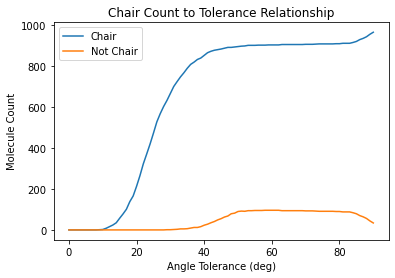

In [34]:
cyclohexanel298.chairCounter()

In [39]:
methyl500 = ConformerCounter("methyl_1000_opls_500.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 1 0
8 2 0
9 2 0
10 6 0
11 11 0
12 18 0
13 29 0
14 36 0
15 48 0
16 74 0
17 104 0
18 125 0
19 158 0
20 187 0
21 233 0
22 274 0
23 308 0
24 345 0
25 387 0
26 428 0
27 453 1
28 494 2
29 524 2
30 560 5
31 587 7
32 607 8
33 624 10
34 646 14
35 666 18
36 684 19
37 697 24
38 712 35
39 725 37
40 733 41
41 745 49
42 751 58
43 765 73
44 773 77
45 779 92
46 780 106
47 784 116
48 793 122
49 793 138
50 795 146
51 801 153
52 802 162
53 805 166
54 808 170
55 809 175
56 812 177
57 814 178
58 815 179
59 815 180
60 815 182
61 815 184
62 815 184
63 816 183
64 817 182
65 818 182
66 818 182
67 819 181
68 820 180
69 820 180
70 820 180
71 820 180
72 820 180
73 820 180
74 821 179
75 822 178
76 823 177
77 823 177
78 823 177
79 823 177
80 826 174
81 827 173
82 829 171
83 836 164
84 843 157
85 848 152
86 865 135
87 880 120
88 892 108
89 914 86
90 931 69


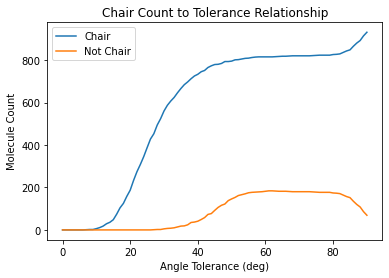

In [40]:
methyl500.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 1 0
10 3 0
11 9 1
12 13 1
13 17 1
14 24 1
15 36 1
16 51 1
17 66 3
18 89 5
19 110 5
20 141 6
21 180 7
22 203 8
23 238 9
24 278 10
25 317 13
26 359 16
27 390 19
28 433 20
29 464 21
30 496 23
31 526 26
32 551 30
33 569 31
34 584 34
35 606 35
36 624 38
37 638 41
38 652 43
39 664 46
40 679 47
41 692 47
42 697 48
43 711 48
44 720 49
45 727 49
46 733 50
47 739 50
48 743 50
49 745 50
50 743 52
51 750 52
52 752 53
53 755 53
54 754 55
55 754 55
56 756 56
57 758 56
58 759 56
59 759 56
60 759 56
61 759 56
62 759 56
63 759 56
64 759 56
65 759 56
66 759 56
67 759 56
68 759 56
69 759 56
70 759 56
71 759 56
72 759 56
73 759 56
74 759 56
75 759 56
76 759 56
77 759 56
78 759 56
79 759 56
80 759 56
81 759 56
82 759 56
83 759 56
84 759 56
85 759 56
86 759 56
87 759 56
88 759 56
89 759 56
90 759 56


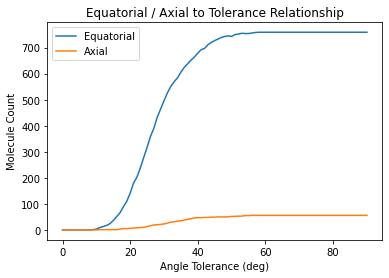

In [41]:
methyl500.equatorialCounter(60)

In [42]:
methyl700 = ConformerCounter("methyl_1000_opls_700.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 1 0
11 2 0
12 5 0
13 10 0
14 16 0
15 24 0
16 36 0
17 46 0
18 60 0
19 86 0
20 106 0
21 125 0
22 147 0
23 171 0
24 203 0
25 232 0
26 257 0
27 285 0
28 306 1
29 331 1
30 356 4
31 380 5
32 406 11
33 423 12
34 446 18
35 465 22
36 486 28
37 509 36
38 528 49
39 542 65
40 550 79
41 560 92
42 568 99
43 578 113
44 586 128
45 595 151
46 597 173
47 601 197
48 608 210
49 610 235
50 614 265
51 619 287
52 621 300
53 629 308
54 637 311
55 639 321
56 641 332
57 643 338
58 644 340
59 645 344
60 647 344
61 647 347
62 649 348
63 651 347
64 653 346
65 656 343
66 658 342
67 661 339
68 662 338
69 664 336
70 666 334
71 666 334
72 666 334
73 669 331
74 672 328
75 674 326
76 676 324
77 676 324
78 678 322
79 683 317
80 689 311
81 692 308
82 698 302
83 707 293
84 717 283
85 739 261
86 759 241
87 778 222
88 805 195
89 838 162
90 876 124


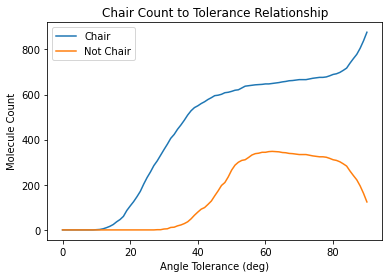

In [43]:
methyl700.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 1 0
12 4 0
13 11 2
14 17 3
15 22 3
16 29 4
17 34 5
18 47 7
19 67 7
20 85 10
21 101 14
22 121 16
23 146 21
24 167 22
25 182 25
26 205 30
27 226 32
28 245 35
29 270 40
30 291 45
31 310 47
32 337 51
33 355 56
34 371 61
35 387 64
36 403 66
37 419 73
38 431 74
39 451 77
40 460 80
41 465 85
42 471 86
43 481 89
44 492 91
45 502 93
46 509 97
47 516 98
48 525 98
49 530 98
50 535 99
51 540 101
52 541 102
53 541 103
54 542 103
55 543 103
56 543 104
57 543 104
58 543 104
59 542 105
60 542 105
61 542 105
62 542 105
63 542 105
64 542 105
65 542 105
66 542 105
67 542 105
68 542 105
69 542 105
70 542 105
71 542 105
72 542 105
73 542 105
74 542 105
75 542 105
76 542 105
77 542 105
78 542 105
79 542 105
80 542 105
81 542 105
82 542 105
83 542 105
84 542 105
85 542 105
86 542 105
87 542 105
88 542 105
89 541 106
90 539 108


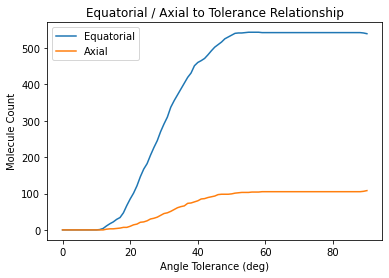

In [45]:
methyl700.equatorialCounter(60)

In [48]:
methyl900 = ConformerCounter("methyl_1000_opls_900.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 1 0
12 2 0
13 3 0
14 9 0
15 11 0
16 14 0
17 21 0
18 31 0
19 38 0
20 50 0
21 61 1
22 79 1
23 98 1
24 117 2
25 131 2
26 145 3
27 170 3
28 188 4
29 207 6
30 225 9
31 237 11
32 252 12
33 264 14
34 273 20
35 284 21
36 298 34
37 313 46
38 324 57
39 341 76
40 354 85
41 366 106
42 383 123
43 397 144
44 402 163
45 414 185
46 426 215
47 437 245
48 449 280
49 456 312
50 460 339
51 466 370
52 474 383
53 484 397
54 493 413
55 496 425
56 503 432
57 507 446
58 511 455
59 516 455
60 524 460
61 527 461
62 532 460
63 539 456
64 544 451
65 548 449
66 552 447
67 557 442
68 560 439
69 560 440
70 563 437
71 563 437
72 567 433
73 572 428
74 577 423
75 579 421
76 583 417
77 589 411
78 594 406
79 596 404
80 600 400
81 609 391
82 615 385
83 624 376
84 635 365
85 660 340
86 675 325
87 700 300
88 727 273
89 771 229
90 827 173


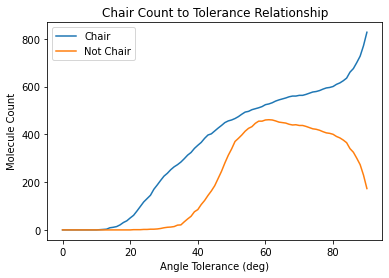

In [49]:
methyl900.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 1 0
10 1 0
11 4 0
12 6 0
13 7 0
14 10 1
15 14 2
16 17 4
17 20 5
18 24 7
19 28 7
20 37 9
21 44 13
22 57 16
23 72 22
24 91 24
25 100 27
26 112 30
27 127 35
28 136 38
29 151 40
30 164 43
31 175 47
32 188 48
33 199 53
34 207 53
35 218 60
36 230 65
37 243 71
38 258 75
39 268 77
40 285 85
41 300 85
42 313 88
43 320 90
44 328 91
45 345 92
46 350 98
47 357 98
48 368 101
49 374 102
50 383 105
51 391 107
52 391 111
53 393 113
54 397 115
55 399 116
56 401 118
57 400 119
58 400 121
59 401 122
60 401 122
61 401 123
62 400 124
63 400 124
64 400 124
65 399 125
66 399 125
67 399 125
68 399 125
69 399 125
70 399 125
71 399 125
72 399 125
73 399 125
74 399 125
75 399 125
76 399 125
77 399 125
78 399 125
79 399 125
80 399 125
81 399 125
82 399 125
83 399 125
84 399 125
85 399 125
86 399 125
87 399 125
88 399 125
89 398 126
90 398 126


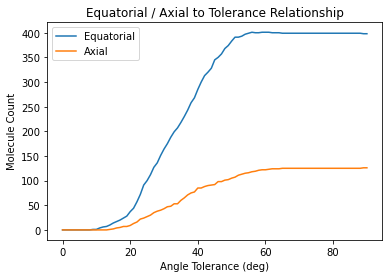

In [50]:
methyl900.equatorialCounter(60)

In [51]:
methyl1100 = ConformerCounter("methyl_1000_opls_1100.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 3 0
15 5 0
16 7 0
17 12 0
18 16 0
19 20 0
20 22 0
21 29 0
22 38 0
23 44 1
24 49 3
25 60 3
26 66 3
27 77 3
28 82 4
29 96 4
30 109 7
31 122 9
32 139 11
33 156 20
34 170 27
35 187 37
36 202 48
37 218 61
38 225 73
39 240 86
40 253 103
41 265 123
42 275 156
43 280 180
44 292 203
45 305 232
46 312 256
47 322 290
48 335 326
49 342 360
50 346 397
51 353 431
52 360 451
53 365 486
54 372 508
55 382 527
56 387 538
57 396 548
58 405 550
59 409 557
60 413 564
61 423 560
62 431 556
63 439 552
64 444 551
65 448 549
66 451 546
67 459 539
68 466 532
69 471 528
70 475 524
71 479 520
72 487 513
73 494 506
74 496 504
75 502 498
76 510 490
77 515 485
78 525 475
79 533 467
80 536 464
81 544 456
82 559 441
83 570 430
84 583 417
85 607 393
86 630 370
87 670 330
88 705 295
89 748 252
90 802 198


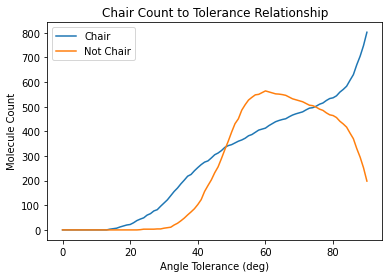

In [52]:
methyl1100.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 1 2
15 1 2
16 3 4
17 6 6
18 9 8
19 14 9
20 17 11
21 19 12
22 21 16
23 26 19
24 32 20
25 39 21
26 47 21
27 52 25
28 59 28
29 69 34
30 74 36
31 84 36
32 99 41
33 108 48
34 113 53
35 120 55
36 133 58
37 141 65
38 151 70
39 161 73
40 174 74
41 184 82
42 197 84
43 206 86
44 212 93
45 226 95
46 233 97
47 248 99
48 258 101
49 262 107
50 266 108
51 274 109
52 280 109
53 281 110
54 282 114
55 282 121
56 284 122
57 287 123
58 285 126
59 284 128
60 283 129
61 282 131
62 281 132
63 281 132
64 281 132
65 280 133
66 280 133
67 280 133
68 280 133
69 280 133
70 280 133
71 280 133
72 280 133
73 280 133
74 280 133
75 280 133
76 280 133
77 280 133
78 280 133
79 280 133
80 280 133
81 280 133
82 280 133
83 280 133
84 280 133
85 280 133
86 280 133
87 280 133
88 280 133
89 279 134
90 278 135


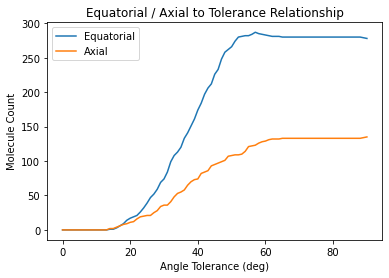

In [53]:
methyl1100.equatorialCounter(60)

In [54]:
methyl1300 = ConformerCounter("methyl_1000_opls_1300.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 1 0
14 2 0
15 2 0
16 4 0
17 5 0
18 11 0
19 14 0
20 17 0
21 23 0
22 27 0
23 32 0
24 34 0
25 41 0
26 48 3
27 60 4
28 69 5
29 78 8
30 87 11
31 94 15
32 103 23
33 115 28
34 125 35
35 137 43
36 149 56
37 160 76
38 171 86
39 182 99
40 195 119
41 205 145
42 212 167
43 223 188
44 228 220
45 237 251
46 247 276
47 259 306
48 268 339
49 278 376
50 284 409
51 294 449
52 305 482
53 315 512
54 324 524
55 332 545
56 343 554
57 349 567
58 354 583
59 357 597
60 371 594
61 376 593
62 381 598
63 389 598
64 396 594
65 401 594
66 406 592
67 411 588
68 415 584
69 420 579
70 424 575
71 428 571
72 434 566
73 439 561
74 445 555
75 451 549
76 458 542
77 463 537
78 469 531
79 478 522
80 489 511
81 502 498
82 514 486
83 524 476
84 537 463
85 560 440
86 593 407
87 625 375
88 677 323
89 720 280
90 777 223


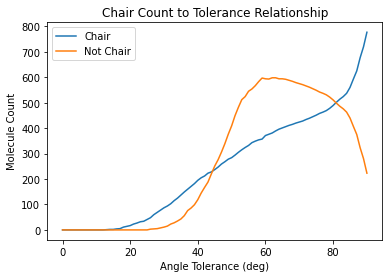

In [55]:
methyl1300.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 1
13 0 1
14 0 1
15 0 2
16 0 3
17 1 3
18 2 3
19 3 3
20 3 4
21 5 5
22 6 5
23 12 7
24 16 12
25 18 16
26 22 20
27 26 24
28 37 28
29 41 34
30 48 36
31 56 38
32 61 40
33 65 45
34 71 50
35 78 55
36 83 58
37 94 61
38 104 65
39 119 71
40 125 75
41 135 79
42 143 83
43 150 87
44 162 89
45 173 91
46 184 93
47 191 100
48 199 102
49 210 105
50 215 109
51 220 113
52 227 114
53 235 115
54 238 117
55 239 119
56 242 120
57 244 120
58 246 120
59 244 123
60 243 125
61 245 125
62 245 125
63 244 126
64 242 128
65 242 128
66 243 128
67 242 129
68 242 129
69 241 130
70 241 130
71 241 130
72 241 130
73 241 130
74 241 130
75 241 130
76 241 130
77 241 130
78 241 130
79 241 130
80 241 130
81 241 130
82 241 130
83 241 130
84 240 131
85 240 131
86 240 131
87 240 131
88 240 131
89 240 131
90 239 132


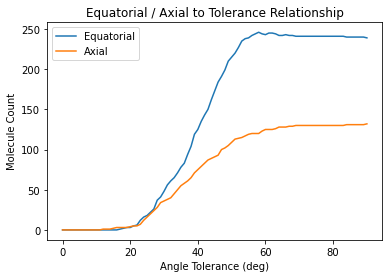

In [56]:
methyl1300.equatorialCounter(60)

In [57]:
methyl1500 = ConformerCounter("methyl_1000_opls_1500.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 1 0
14 1 0
15 1 0
16 2 0
17 3 0
18 4 0
19 7 0
20 7 0
21 8 0
22 10 0
23 14 0
24 15 0
25 19 1
26 26 1
27 37 1
28 39 2
29 44 3
30 54 4
31 63 5
32 74 13
33 83 20
34 89 25
35 98 34
36 114 46
37 123 59
38 131 71
39 146 88
40 154 110
41 166 129
42 176 149
43 189 177
44 201 199
45 210 233
46 220 278
47 233 309
48 244 329
49 254 356
50 261 397
51 274 434
52 279 469
53 291 492
54 300 513
55 309 535
56 314 553
57 319 565
58 326 583
59 328 598
60 334 611
61 343 621
62 348 626
63 355 623
64 362 620
65 370 615
66 375 613
67 384 607
68 386 607
69 392 604
70 402 598
71 411 589
72 418 582
73 425 575
74 432 568
75 441 559
76 448 552
77 457 543
78 469 531
79 480 520
80 490 510
81 503 497
82 510 490
83 526 474
84 553 447
85 577 423
86 600 400
87 635 365
88 675 325
89 730 270
90 783 217


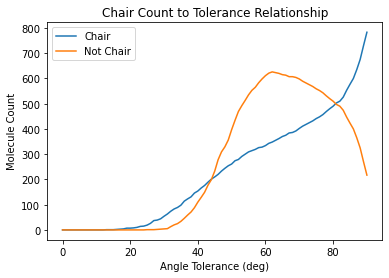

In [58]:
methyl1500.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 1 0
10 1 0
11 1 0
12 1 0
13 1 0
14 1 0
15 1 0
16 1 1
17 2 1
18 3 3
19 4 5
20 5 5
21 6 5
22 7 5
23 10 8
24 15 9
25 17 11
26 21 14
27 25 14
28 25 17
29 31 18
30 36 19
31 43 24
32 48 28
33 57 32
34 60 38
35 68 41
36 76 45
37 81 50
38 86 52
39 96 55
40 102 58
41 112 65
42 121 71
43 134 71
44 145 72
45 155 78
46 163 81
47 173 84
48 182 86
49 192 90
50 196 94
51 203 97
52 208 99
53 211 103
54 215 104
55 219 105
56 220 106
57 219 110
58 217 113
59 218 113
60 219 114
61 219 114
62 219 114
63 219 114
64 217 116
65 217 117
66 217 117
67 217 117
68 217 117
69 217 117
70 217 117
71 216 118
72 216 118
73 216 118
74 215 119
75 215 119
76 214 120
77 213 121
78 213 121
79 213 121
80 213 121
81 213 121
82 213 121
83 212 122
84 212 122
85 212 122
86 211 123
87 211 123
88 211 123
89 209 125
90 207 127


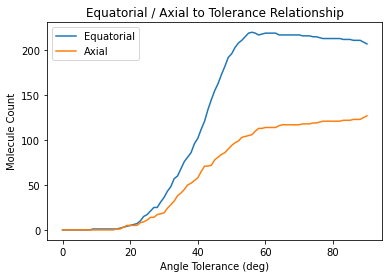

In [59]:
methyl1500.equatorialCounter(60)

In [60]:
methyl1700 = ConformerCounter("methyl_1000_opls_1700.gro", "methyl_1_opls.itp")

Angle | Chairs | Twist Boats
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 1 0
14 1 0
15 1 0
16 2 0
17 3 0
18 3 0
19 4 1
20 7 1
21 7 1
22 10 1
23 12 1
24 16 2
25 23 2
26 28 3
27 35 4
28 45 6
29 53 10
30 59 14
31 64 17
32 76 22
33 93 31
34 103 41
35 108 54
36 119 59
37 133 68
38 139 80
39 151 95
40 162 109
41 166 131
42 173 156
43 179 177
44 193 203
45 205 222
46 215 247
47 226 273
48 241 306
49 247 326
50 253 356
51 261 388
52 264 426
53 275 456
54 280 491
55 285 512
56 288 532
57 295 548
58 300 564
59 311 578
60 316 591
61 322 603
62 328 611
63 330 624
64 335 628
65 343 628
66 352 625
67 359 626
68 366 623
69 371 623
70 376 620
71 381 616
72 392 605
73 398 600
74 407 592
75 418 582
76 425 575
77 432 568
78 439 561
79 446 554
80 454 546
81 469 531
82 481 519
83 495 505
84 510 490
85 533 467
86 554 446
87 588 412
88 640 360
89 688 312
90 733 267


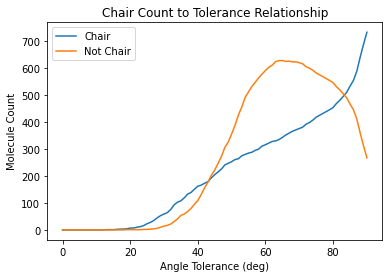

In [61]:
methyl1700.chairCounter()

Angle | Equatorial | Axial
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 1 0
16 2 0
17 4 0
18 4 0
19 4 0
20 7 3
21 8 5
22 9 7
23 11 7
24 16 8
25 19 11
26 20 16
27 26 18
28 29 20
29 34 23
30 36 26
31 45 26
32 54 29
33 61 33
34 65 36
35 69 37
36 72 41
37 82 46
38 89 48
39 94 51
40 104 56
41 110 60
42 117 63
43 122 66
44 139 70
45 147 72
46 155 75
47 163 83
48 169 85
49 175 87
50 180 89
51 184 93
52 187 94
53 193 96
54 195 100
55 201 100
56 203 102
57 205 102
58 207 105
59 204 109
60 202 112
61 202 112
62 202 112
63 202 112
64 203 113
65 202 114
66 202 114
67 202 114
68 201 115
69 201 115
70 200 116
71 200 116
72 200 116
73 200 116
74 200 116
75 200 116
76 200 116
77 200 116
78 200 116
79 200 116
80 200 116
81 200 116
82 200 116
83 200 116
84 200 116
85 200 116
86 200 116
87 200 116
88 200 116
89 200 116
90 200 116


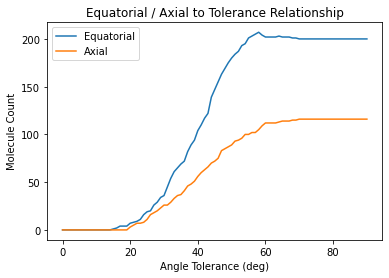

In [62]:
methyl1700.equatorialCounter(60)